# ASL Alphabet Dataset

This dataset contains images of hand signs used in the **American Sign Language (ASL) alphabet**.  
It includes all **26 letters (A–Z)**, with about **3,000 images for each letter** in both the training and testing sets.

### Additional Signs
Besides the alphabet, the dataset includes three extra signs:

- **Delete**
- **Space**
- **Nothing**

### Summary
- **Total classes:** 29  
- **Images per class:** ~3,000  
- **Total images:** ~87,000  



# Importing Libraries

In [1]:
# Installing Media pipe for landmarks Extractions
!pip install mediapipe 

INFO: pip is looking at multiple versions of opencv-contrib-python to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.6/35.6 MB 43.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 19.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.1/69.1 MB 25.0 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:
      Successfully uninstalled protobuf-3.20.3
  Attempting uninstall: opencv-contrib-python
    Found existing installation: opencv-contrib-python 4.12.0.88
    Uninstalling opencv-contrib-python-4.12.0.88:
      Successfully uninstalled opencv-contrib-python-4.12.0.88
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.12.0 re

In [15]:
import numpy as np
import pandas as pd
import os
import cv2
import mediapipe as mp
import pickle
import tensorflow as tf
import shutil
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout,BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

# Reading the data

In [16]:
train_dir = '/kaggle/input/asl-alphabet/asl_alphabet_train/asl_alphabet_train'
test_dir = '/kaggle/input/asl-alphabet/asl_alphabet_test/asl_alphabet_test'

classes = sorted(os.listdir(train_dir))
print(f"Classes: {classes} ...")

Classes: ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'del', 'nothing', 'space'] ...


# Preprocessing

## Intializing Mediapipe for landmarks extraction

In [17]:
mp_hands = mp.solutions.hands
hands_static = mp_hands.Hands(static_image_mode=True, # For reading the photos
                              max_num_hands=1,    # 1 hand per photo
                              min_detection_confidence=0.5     # Confidence level per photo 
                             )


W0000 00:00:1763410598.553108     128 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1763410598.587364     128 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


## 1.Hand Landmark Extraction with MediaPipe

This function extracts **21 hand landmarks** from an input image. Each landmark provides **x, y, z coordinates**, resulting in **63 features** per hand $(21 \times 3)$.

---

## 1. MediaPipe Hand Detection

* MediaPipe detects hands using a **deep learning model**.
* For each detected hand, it returns **21 key points** representing important joints and fingertips. 
* Landmarks are **normalized** relative to the image size:

$$
x_{\text{norm}} = \frac{x_{\text{pixel}}}{w}, \quad y_{\text{norm}} = \frac{y_{\text{pixel}}}{h}, \quad z_{\text{norm}} \in [-1, 1]
$$

Where:  
* $x_{\text{norm}}, y_{\text{norm}}$ $\rightarrow$ normalized 2D coordinates  
* $z_{\text{norm}}$ $\rightarrow$ depth coordinate (**distance from camera**), relative to the wrist depth.  
* $w, h$ $\rightarrow$ width and height of the input image in pixels.  

---

## 2. Converting to Pixel Coordinates

To map the normalized coordinates back to actual image pixels:

$$
x_{\text{pixel}} = x_{\text{norm}} \cdot w
$$  
$$
y_{\text{pixel}} = y_{\text{norm}} \cdot h
$$

* $x_{\text{pixel}}, y_{\text{pixel}}$ are now in **image coordinates**.
* The depth $z_{\text{norm}}$ is typically left normalized for pose analysis, as its scale is non-linear and device-dependent.

---

## 3. Creating the Feature Vector

All 21 landmarks are flattened into a single feature vector $\mathbf{F}$:

$$
\mathbf{F} = [x_1, y_1, z_1, \; x_2, y_2, z_2, \; \dots, \; x_{21}, y_{21}, z_{21}] \in \mathbb{R}^{63}
$$

* This vector encodes the **spatial structure of the hand's pose and shape**.
* Can be used as input features for **gesture classification** or other **machine learning models**.

---

## 4. Logic Summary

1.  Load the image.  
2.  Convert from **BGR $\rightarrow$ RGB** (required by MediaPipe).  
3.  Detect hands and extract **21 normalized landmarks**.  
4.  Flatten the $(x, y, z)$ coordinates into a **63-dimensional vector**.  
5.  Return the vector, or $\text{None}$ if no hand is detected.

This approach captures the hand’s **shape and pose** numerically, enabling accurate gesture recognition.

In [23]:
# Extract Landmarks Function 
def extract_landmarks(image_path):
    """Extract 21 hand landmarks (63 features: x, y, z for each point)"""
    # read the image in numpy array with BGR format
    image = cv2.imread(image_path)
    # Check if the image empty
    if image is None:
        return None
    # Converts to RGB
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # Process it with the object of Media pipe 
    results = hands_static.process(image_rgb)
    # Checks if any hand detected
    if results.multi_hand_landmarks:
        # get the first hand detected
        landmarks = results.multi_hand_landmarks[0]
        # Intiallize Corrdanate list
        coords = []
        # Extract x, y, z coordinates
        for lm in landmarks.landmark:
            coords.extend([lm.x, lm.y, lm.z])
        # Converts the coordinats into numpy array and return it
        return np.array(coords)  
    return None

### Apply the function

In [24]:
# X array for all 63 corridnaate per hand
X_data = []
# For classes
y_data = []
# Define the classes
classes = sorted(os.listdir(train_dir))
print(f"Found {len(classes)} classes of {classes}")
# Iterate through each class image in the cropped images
for class_name in classes:
    class_path = os.path.join(train_dir, class_name)
    # skips the hidden files 
    if not os.path.isdir(class_path):
        continue
    # Starts preprocessing images 
    print(f"Processing class: {class_name}")
    files = [f for f in os.listdir(class_path) if f.endswith(('.jpg', '.png', '.jpeg'))]
    # COunt how many extracted correctly
    success_count = 0
    # Loops through each image and extract it
    for file in tqdm(files, desc=f"Extracting {class_name}", leave=False):
        img_path = os.path.join(class_path, file)
        landmarks = extract_landmarks(img_path)
        # If it extracted succecfully append into x and y
        if landmarks is not None:
            X_data.append(landmarks)
            y_data.append(class_name)
            success_count += 1
    
    print(f"Succisfully extracted {success_count} from {len(files)} samples")

print(f"\nTotal samples extracted: {len(X_data)}")

Found 29 classes of ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'del', 'nothing', 'space']
Processing class: A


Succisfully extracted 2187 from 3000 samples
Processing class: B


Succisfully extracted 2207 from 3000 samples
Processing class: C


Succisfully extracted 1988 from 3000 samples
Processing class: D


Succisfully extracted 2463 from 3000 samples
Processing class: E


Succisfully extracted 2308 from 3000 samples
Processing class: F


Succisfully extracted 2876 from 3000 samples
Processing class: G


Succisfully extracted 2440 from 3000 samples
Processing class: H


Succisfully extracted 2393 from 3000 samples
Processing class: I


Succisfully extracted 2384 from 3000 samples
Processing class: J


Succisfully extracted 2578 from 3000 samples
Processing class: K


Succisfully extracted 2700 from 3000 samples
Processing class: L


Succisfully extracted 2527 from 3000 samples
Processing class: M


Succisfully extracted 1565 from 3000 samples
Processing class: N


Succisfully extracted 1276 from 3000 samples
Processing class: O


Succisfully extracted 2265 from 3000 samples
Processing class: P


Succisfully extracted 2042 from 3000 samples
Processing class: Q


Succisfully extracted 2093 from 3000 samples
Processing class: R


Succisfully extracted 2541 from 3000 samples
Processing class: S


Succisfully extracted 2551 from 3000 samples
Processing class: T


Succisfully extracted 2349 from 3000 samples
Processing class: U


Succisfully extracted 2516 from 3000 samples
Processing class: V


Succisfully extracted 2548 from 3000 samples
Processing class: W


Succisfully extracted 2456 from 3000 samples
Processing class: X


Succisfully extracted 2158 from 3000 samples
Processing class: Y


Succisfully extracted 2585 from 3000 samples
Processing class: Z


Succisfully extracted 2351 from 3000 samples
Processing class: del


Succisfully extracted 1701 from 3000 samples
Processing class: nothing


Succisfully extracted 3 from 3000 samples
Processing class: space


Succisfully extracted 1625 from 3000 samples

Total samples extracted: 63676


In [25]:
# Remove "nothing" class samples (only has 3 samples)
print(f"Before filtering: {len(X_data)} samples")

# Find indices where class is NOT "nothing"
keep_indices = [i for i, label in enumerate(y_data) if label.lower() != 'nothing']

# Filter both X and y
X_data_filtered = [X_data[i] for i in keep_indices]
y_data_filtered = [y_data[i] for i in keep_indices]

# Replace original data
X_data = X_data_filtered
y_data = y_data_filtered

print(f"After filtering: {len(X_data)} samples")
print(f"Removed 'nothing' class")

# Check remaining classes
unique_classes = sorted(set(y_data))
print(f"Training on {len(unique_classes)} classes: {unique_classes}")

Before filtering: 63676 samples
After filtering: 63673 samples
Removed 'nothing' class
Training on 28 classes: ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'del', 'space']


## Pre modeling

In [26]:
# Transform X and y to array for splitting
X = np.array(X_data)
y = np.array(y_data)

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_categorical = to_categorical(y_encoded)

# Train-validation split
X_train, X_val, y_train, y_val = train_test_split(
    X, y_categorical, test_size=0.15, random_state=42, stratify=y_encoded
)

print(f"Training samples: {X_train.shape[0]}")
print(f"Validation samples: {X_val.shape[0]}")
print(f"Number of classes: {len(label_encoder.classes_)}")
print(f"Feature dimension: {X_train.shape[1]} (21 landmarks × 3 coordinates)")


Training samples: 54122
Validation samples: 9551
Number of classes: 28
Feature dimension: 63 (21 landmarks × 3 coordinates)


# Modeling

In [27]:
# Define number of classes
num_classes = len(label_encoder.classes_)
# Build a sequential model
model = Sequential([
    # 256 Dense layer
    Dense(256, activation='relu', input_shape=(63,)),
    # Normalize activations to stablize training
    BatchNormalization(),
    # Drop out layer to make the model learn more
    Dropout(0.4),
    # Second Dense layer and the same as befor
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    # Third dense layer with the same as before
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),
    # Output layer
    Dense(num_classes, activation='softmax')
])
# COmpile the model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
# GEt number of parameters per layer
model.summary()

# Callbacks 
callbacks = [
    # If the model didn't improve for 10 epochs stop the training to prevent overfitting
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True), 
    # Save the best model in training
    ModelCheckpoint('asl_landmarks_best.h5', save_best_only=True, monitor='val_accuracy'),
    # Reduce learning rate by .5 if the loss stops improving per 5 epochs
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-7)
]

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1763412962.390140      39 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │        16,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 28)             │         1,820 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 61,148 (238.86 KB)

 Trainable params: 60,252 (235.36 KB)

 Non-trainable params: 896 (3.50 KB)

In [28]:
# Train Model 
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=128,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/100


I0000 00:00:1763412969.756861     142 service.cc:148] XLA service 0x3e3dab80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1763412969.757336     142 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1763412970.156614     142 cuda_dnn.cc:529] Loaded cuDNN version 90300


 62/423 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1672 - loss: 3.1681

I0000 00:00:1763412972.596481     142 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


423/423 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.5640 - loss: 1.6216 - val_accuracy: 0.7219 - val_loss: 0.9252 - learning_rate: 0.0010
Epoch 2/100
423/423 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9315 - loss: 0.2528 - val_accuracy: 0.9130 - val_loss: 0.2656 - learning_rate: 0.0010
Epoch 3/100
423/423 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9393 - loss: 0.2138 - val_accuracy: 0.8949 - val_loss: 0.3039 - learning_rate: 0.0010
Epoch 4/100
423/423 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9463 - loss: 0.1875 - val_accuracy: 0.9127 - val_loss: 0.2735 - learning_rate: 0.0010
Epoch 5/100
423/423 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9487 - loss: 0.1784 - val_accuracy: 0.9733 - val_loss: 0.1108 - learning_rate: 0.0010
Epoch 6/100
423/423 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9507 - loss: 0.1665 - val_accuracy: 0.8766 - val_loss: 0.3643 - learning_rate: 0.0010
Epoch 7/100
423/423 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9509 - loss: 0.1622 - val

In [29]:
# Save the trained model and its classes
model.save('asl_landmarks_final.h5')
with open('asl_landmarks_classes.pkl', 'wb') as f:
    pickle.dump(label_encoder.classes_, f)

print("Model and classes saved successfully!")

Model and classes saved successfully!


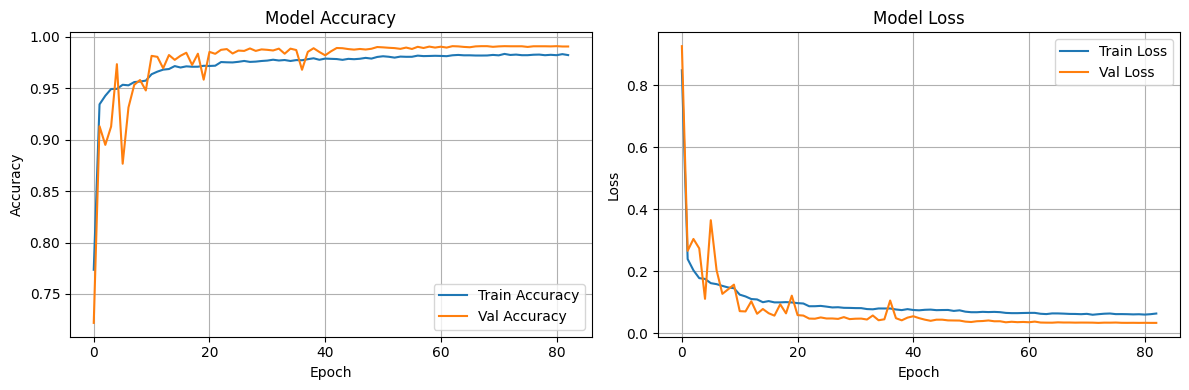

In [30]:
# Visualize Training and validating
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [31]:
val_loss, val_accuracy = model.evaluate(X_val, y_val, verbose=0)
print(f"\nFinal Validation Accuracy= {val_accuracy*100:.2f}%")
print(f"Final Validation Loss= {val_loss:.4f}")


Final Validation Accuracy= 99.07%
Final Validation Loss= 0.0334
